In [16]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

In [17]:
Xop=sp.sparse.csr_array([[0.,1.],[1.,0.]]) # Pauli X
Yop=sp.sparse.csr_array([[0,-1j],[1j,0.]])
Zop=sp.sparse.csr_array([[1.,0.],[0.,-1]])

In [18]:
def operator(op,idx,N):
  """
  Produce an operator that has single-qubit operator op acting
  on qubit with index idx, and the rest is identity. N is the total number of qubits.
  idx count starts at 0 and runs up to N-1.

  Example: Z_3
  >> operator(Zop,3,10)

  Example: X_0 X_2
  >>  operator(Xop,0,10) @ operator(Xop,2,10)
  """
  return sp.sparse.kron( sp.sparse.identity(2**idx), sp.sparse.kron(op, sp.sparse.identity(2**(N-idx-1))) )

def expectation(psi,op):
  """
  Calculate the expectation value of observable operator op with respect to state psi.
  This takes the real part automatically, assuming op is Hermitean !
  """

  return np.real( np.sum( np.conj(psi) * (op @ psi) ) )

def empty_matrix(n_dim):
  """
  Return the empty sparse matrix for a system of Hilbert space dimension n_dim.
  """
  return sp.sparse.csr_matrix((n_dim, n_dim), dtype='complex')

def produce_XYZ(N):
  """
  Return X,Y,Z = a list of all Pauli X operators, all Pauli Y, all Pauli Z,
  for given qubit number N
  """
  return ( [operator(Xop,idx,N) for idx in range(N)] ,
            [operator(Yop,idx,N) for idx in range(N)] ,
            [operator(Zop,idx,N) for idx in range(N)] )

def ground_state(H):
  """
  Return ground state of H, using sparse Lanczos.
  Returns eigenvalue, eigenvector
  """
  evals,evecs=sp.sparse.linalg.eigsh(H, k=1, which='SA')
  return evals[0], evecs[:,0]


System dimensions

In [19]:
# generate all the single-qubit operators:
N = 10 # qubit number
X,Y,Z = produce_XYZ(N)

Hamiltonian (OBC to mostly avoid steps and discontinuities; also closer to experiments)

In [20]:
## example:

H0_terms = [sum([X[j] for j in range(0,N)])]

H_theta_terms = [
  sum([Z[j] @ Z[j+1] for j in range(0,N-1)])
  ]

H_out = [X[0] @ X[4]]

g_ZXZ = .5
H_const = g_ZXZ * sum([Z[j] @ X[(j+1)%N] @ Z[(j+2)%N] for j in range(1,N-2)]) ## topological term


def HamiltonianSensor(gx, H0_terms, theta, H_theta_terms, H_out, out_coupl):
  """
  Construct a QEP Hamiltonian from the given components.

  H0 - untrainable terms in Hamiltonian
  H0_terms - terms for the untrainable part of the Hamiltonian

  theta - a vector (list or array) of trainable parameters
  H_theta_terms - a list of corresponding terms in the Hamiltonian

  Returns the Hamiltonian H as a sum of all these terms.
  """

  H = sp.sparse.csr_matrix((2**N, 2**N))

  ## magnetic field part -> optimize slope w.r.t. this parameter
  for jj in range(0,len(gx)):
    H += gx[jj] * H0_terms[jj]

  ## trained part of Hamiltonian
  for jj in range(0,len(theta)):
    H += theta[jj] * H_theta_terms[jj]
  
  ## output part of Hamiltonian
  for jj in range(0,len(out_coupl)):
    H += out_coupl[jj] * H_out[jj]

  ## fixed constant term
  H += H_const

  return -H

In [21]:
## maximizes derivative
def cost_func(gx_1, gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl):
    _, eigVect_1 = ground_state(HamiltonianSensor(gx_1, H0_terms, theta, H_theta_terms, H_out, out_coupl))
    _, eigVect_2 = ground_state(HamiltonianSensor(gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl))
    return - np.abs(np.sqrt(sum(((expectation(eigVect_1, H_out[jj]) - expectation(eigVect_2, H_out[jj])) / np.linalg.norm(gx_1 - gx_2))**2 for jj in range(0,len(out_coupl)))))

In [22]:
def get_gradient(gx_1, gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl, nudge):

    _, eigVect_1 = ground_state(HamiltonianSensor(gx_1, H0_terms, theta, H_theta_terms, H_out, out_coupl))
    _, eigVect_2 = ground_state(HamiltonianSensor(gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl))

    ## one shouldn't use the 'error_signal' for the nudging here, since the error signal is just the ordering relation between the two expectation values
    ## using this for the nudging leads to a repulsion between the two points
    expect_sign = np.array([np.sign(expectation(eigVect_1, H_out[jj]) - expectation(eigVect_2, H_out[jj])) for jj in range(0,len(H_out))])
    
    _, eigVect_1_nudge = ground_state(HamiltonianSensor(gx_1, H0_terms, theta, H_theta_terms, H_out, out_coupl + np.array([nudge])))
    _, eigVect_2_nudge = ground_state(HamiltonianSensor(gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl + np.array([nudge])))

    diff_gx = np.linalg.norm(gx_1 - gx_2)
    
    diff_theta_1 = np.array([[expect_sign[0] * (expectation(eigVect_1_nudge, H_theta_terms[jj]) - expectation(eigVect_1, H_theta_terms[jj]))/(nudge * diff_gx)] for jj in range(0,len(H_theta_terms))])
    diff_theta_2 = np.array([[expect_sign[0] * (expectation(eigVect_2_nudge, H_theta_terms[jj]) - expectation(eigVect_2, H_theta_terms[jj]))/(nudge * diff_gx)] for jj in range(0,len(H_theta_terms))])

    ## total gradient for the training parameters
    diff_theta = diff_theta_1 - diff_theta_2

    gX_sign = np.sign(gx_1[0] - gx_2[0])

    cost_func_val = cost_func(gx_1, gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl)

    ## derivative w.r.t. gX_1 and gX_2
    diff_gX_1 = np.array([[
        expect_sign[0] * (expectation(eigVect_1_nudge, H0_terms[jj]) - expectation(eigVect_1, H0_terms[jj]))/(nudge * diff_gx)
        + gX_sign * cost_func_val/ diff_gx
        ] for jj in range(0,len(H0_terms))])
    diff_gX_2 = - np.array([[
        expect_sign[0] * (expectation(eigVect_2_nudge, H0_terms[jj]) - expectation(eigVect_2, H0_terms[jj]))/(nudge * diff_gx)
        + gX_sign * cost_func_val/ diff_gx
        ] for jj in range(0,len(H0_terms))])

    gradient_norm = np.sqrt(np.linalg.norm(diff_gX_1)**2 + np.linalg.norm(diff_gX_2)**2 + np.linalg.norm(diff_theta)**2)

    return -diff_gX_1 / gradient_norm, -diff_gX_2 / gradient_norm, -diff_theta / gradient_norm

Training, run 1: two initial points in different phases

In [813]:
## option 1: initialise randomly
theta_start = 2 * (np.random.randn(len(H_theta_terms)) - .5)
gx_1_start = 2 * (np.random.randn(len(H0_terms)) - .5)
Delta_gx = 2 * (np.random.randn(len(H0_terms)) - .5)
gx_2_start = gx_1_start + 0.1 * Delta_gx

In [147]:
## option 2: initialise by hand
theta_start = np.array([-1.5])
gx_1_start = np.array([-0.2])
gx_2_start = np.array([-1.5])

In [148]:
## initialise
theta = theta_start
gx_1 = gx_1_start
gx_2 = gx_2_start

## learning rate
learning_rate = 1e-1

## number of total runs
number_epochs = 100

## batch size
batch_size = 2

## iterations
number_iterations = number_epochs #int(number_epochs * len(x_train) / batch_size)

## coupling to output operator (when not in nudge phase)
out_coupl = [0.0]

## nudge parameter scaling eta (uses eta * error_signal)
nudge = 1e-1

In [149]:
cost_func_list = np.array([])

learning_rate_decay = 0.0
epoch = 0

gx_1_list = np.array([])
gx_2_list = np.array([])
theta_list = np.array([])

learning_rate_t = learning_rate

for jj in range(0,number_iterations):
    tmp_grad_gx_1, tmp_grad_gx_2, tmp_grad_theta = get_gradient(gx_1, gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl, nudge)
    tmp_cost_func = cost_func(gx_1, gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl)

    ## learning rate decay (optional; we did not see any advantage of learning rate decay for the examples below)
    #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
    #epoch += 1

    gx_1_list = np.append(gx_1_list, gx_1)
    gx_2_list = np.append(gx_2_list, gx_2)
    theta_list = np.append(theta_list, theta)

    gx_1 -= learning_rate_t * tmp_grad_gx_1.flatten()
    gx_2 -= learning_rate_t * tmp_grad_gx_2.flatten()
    theta -= learning_rate_t * tmp_grad_theta.flatten()

    cost_func_list = np.append(cost_func_list, tmp_cost_func)

gx_1_list = np.append(gx_1_list, gx_1)
gx_2_list = np.append(gx_2_list, gx_2)
theta_list = np.append(theta_list, theta)
cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [56]:
import os
cwd = os.getcwd()
os.chdir(".") ## <-- insert relevant directory here. This is for saving the plots and data.

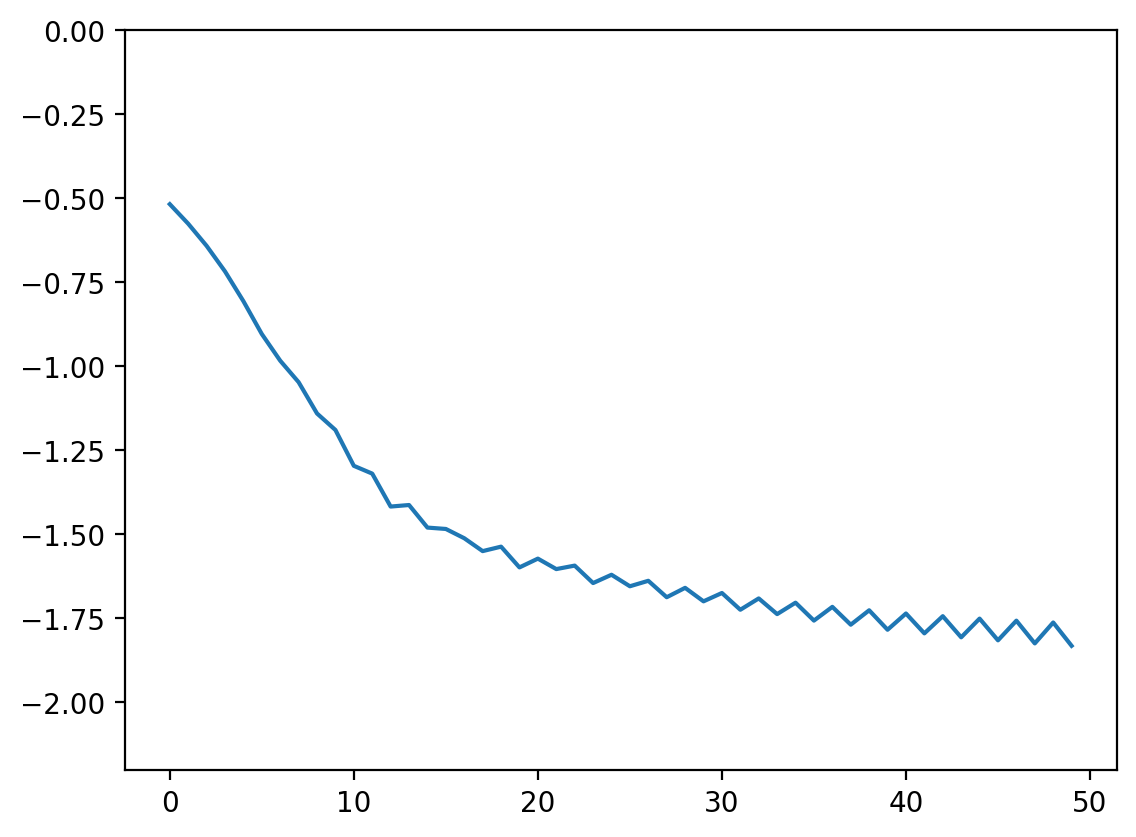

In [93]:
plt.plot(cost_func_list[:50])
plt.ylim([-2.2,0])

plt.savefig('cost_function.pdf')

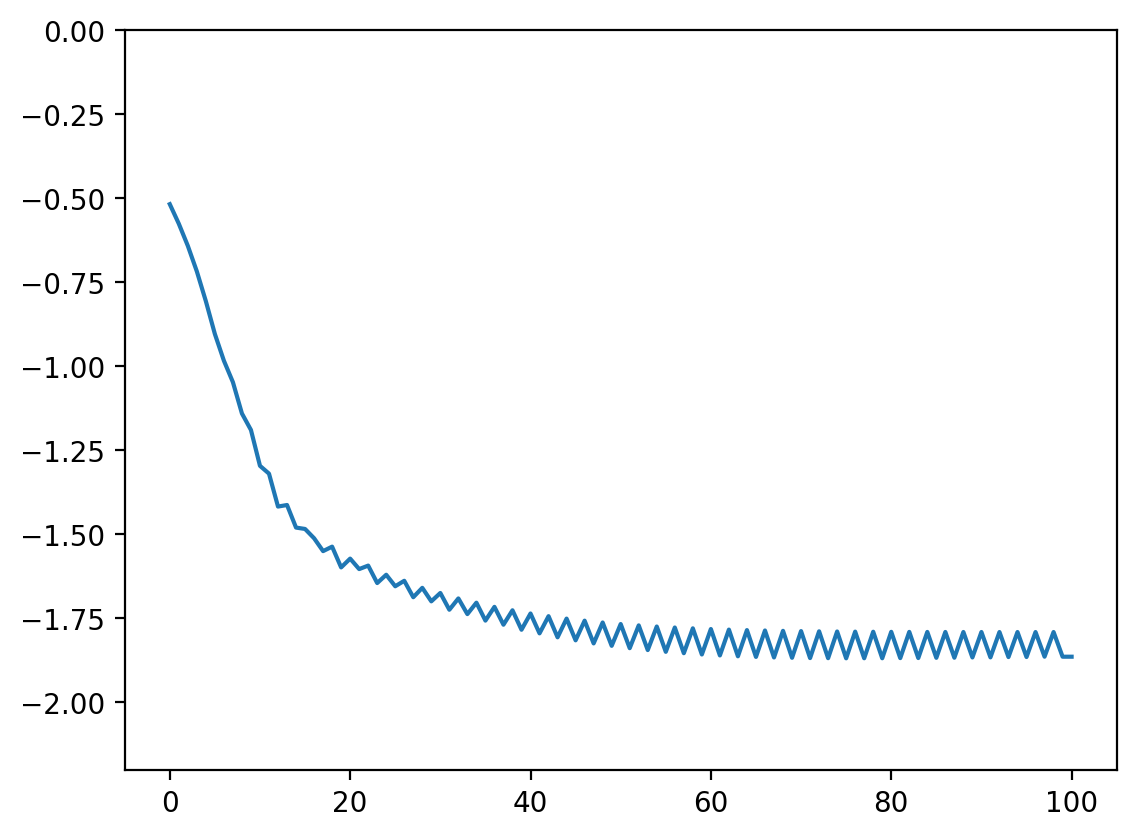

In [94]:
plt.plot(cost_func_list)
plt.ylim([-2.2,0])

plt.savefig('cost_function.pdf')

Check phase diagram

In [34]:
def phase_diagram_2D(op, h_min, h_max, sweep_index, theta, out_coupl, resolution):
    tmp = np.zeros((resolution,resolution))
    theta_sweep = theta
    for jj in range(0,resolution):
        for ll in range(0,resolution):
            gx = np.array([h_min + jj * (h_max - h_min)/resolution])
            h2 = h_min + ll * (h_max - h_min)/resolution
            theta_sweep[sweep_index] = h2
            _, eigVect = ground_state(HamiltonianSensor(gx, H0_terms, theta_sweep, H_theta_terms, H_out, out_coupl))
            tmp[ll,jj] = expectation(eigVect, op)
    return tmp

In [35]:
def phase_diagram_1Dslice(op, h_min, h_max, theta, out_coupl, resolution):
    tmp = np.zeros((resolution))
    for jj in range(0,resolution):
        gx = np.array([h_min + jj * (h_max - h_min)/resolution])
        _, eigVect = ground_state(HamiltonianSensor(gx, H0_terms, theta, H_theta_terms, H_out, out_coupl))
        tmp[jj] = expectation(eigVect, op)
    return tmp

In [79]:
## sweep parameters of X[j] term and Z[j] @ Z[j+1] terms
phase_diag_slice = phase_diagram_2D(H_out[0], -1.71, 1.7, 0, np.array([0.0]), out_coupl, 100)

In [150]:
theta_list = theta_list.reshape((number_epochs+1,len(theta)))

In [81]:
np.savetxt("gx_2_list.csv", gx_2_list, delimiter=",")
np.savetxt("gx_1_list.csv", gx_1_list, delimiter=",")
np.savetxt("theta_list_OBC.csv", theta_list, delimiter=",")
np.savetxt("cost_func_list_OBC.csv", cost_func_list, delimiter=",")
np.savetxt("phase_diag_slice_OBC.csv", phase_diag_slice, delimiter=",")

In [84]:
red_color_list = [[x, 0, 0, 1.0] for x in np.arange(0.0,1,1/len(gx_1_list))]
blue_color_list = [[0, 0, x, 1.0] for x in np.arange(0.0,1,1/len(gx_1_list))]

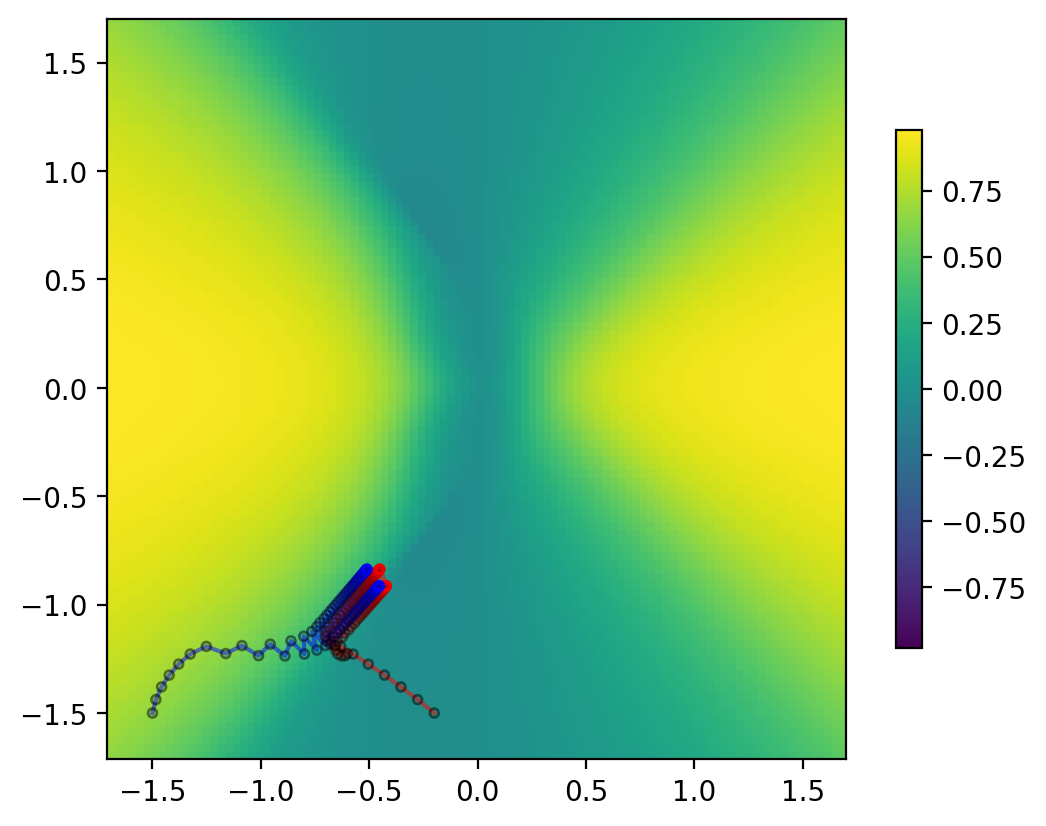

In [101]:
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

plt.imshow(phase_diag_slice, extent = [-1.71, 1.7, -1.71, 1.7],origin='lower',norm=colors.CenteredNorm())
plt.colorbar(shrink = .7)

max_Iter = 100

plt.plot(gx_1_list[:max_Iter], theta_list[:max_Iter,0], c='r', zorder=0, alpha=0.5)
plt.plot(gx_2_list[:max_Iter], theta_list[:max_Iter,0], c='b', zorder=0, alpha=0.5)

plt.scatter(gx_1_list[:max_Iter], theta_list[:max_Iter,0], facecolors='none', edgecolors=red_color_list, s=10, zorder=1, alpha=0.5)
plt.scatter(gx_2_list[:max_Iter], theta_list[:max_Iter,0], facecolors='none', edgecolors=blue_color_list, s=10, zorder=1, alpha=0.5)

plt.savefig('walk_in_phase_diag_2.pdf')

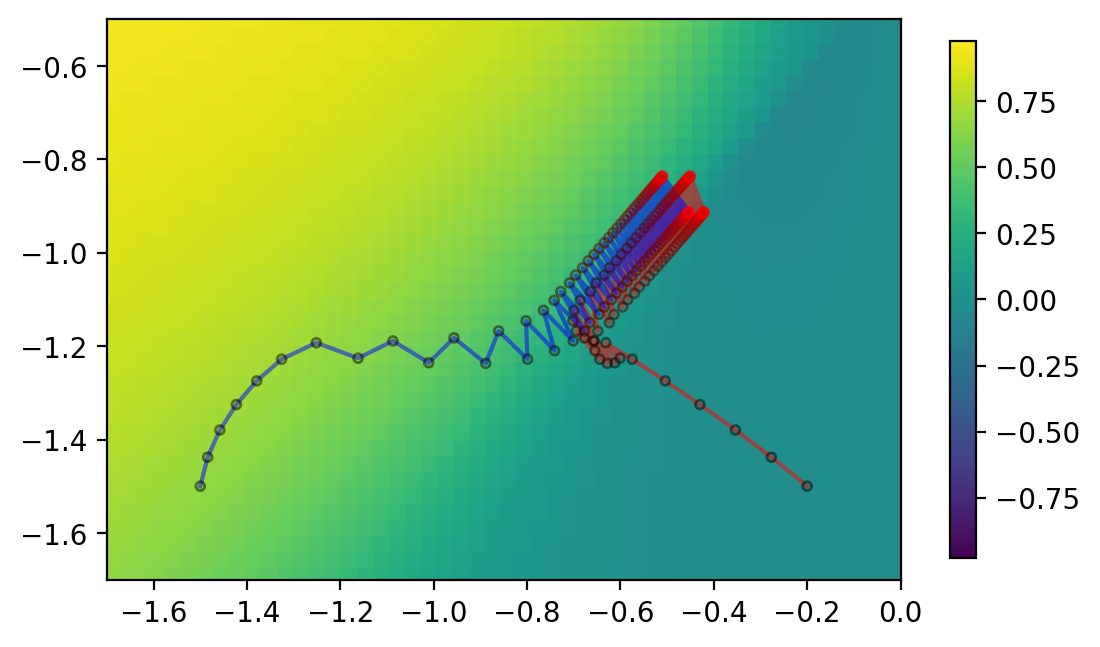

In [151]:
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

plt.imshow(phase_diag_slice, extent = [-1.71, 1.7, -1.71, 1.7],origin='lower',norm=colors.CenteredNorm())
plt.colorbar(shrink = .7)

max_Iter = 100

plt.plot(gx_1_list[:max_Iter], theta_list[:max_Iter,0], c='r', zorder=0, alpha=0.5)
plt.plot(gx_2_list[:max_Iter], theta_list[:max_Iter,0], c='b', zorder=0, alpha=0.5)

plt.scatter(gx_1_list[:max_Iter], theta_list[:max_Iter,0], facecolors='none', edgecolors=red_color_list, s=10, zorder=1, alpha=0.5)
plt.scatter(gx_2_list[:max_Iter], theta_list[:max_Iter,0], facecolors='none', edgecolors=blue_color_list, s=10, zorder=1, alpha=0.5)

plt.xlim([-1.7,0])
plt.ylim([-1.7,-.5])

plt.savefig('walk_in_phase_diag_zoomIn.pdf')

In [123]:
phase_diag_slice_0 = phase_diagram_1Dslice(H_out[0], -1.7, 0.0, theta_list[0], out_coupl, 50)

In [124]:
phase_diag_slice_10 = phase_diagram_1Dslice(H_out[0], -1.7, 0.0, theta_list[10], out_coupl, 50)

In [125]:
phase_diag_slice_40 = phase_diagram_1Dslice(H_out[0], -1.7, 0.0, theta_list[40], out_coupl, 50)

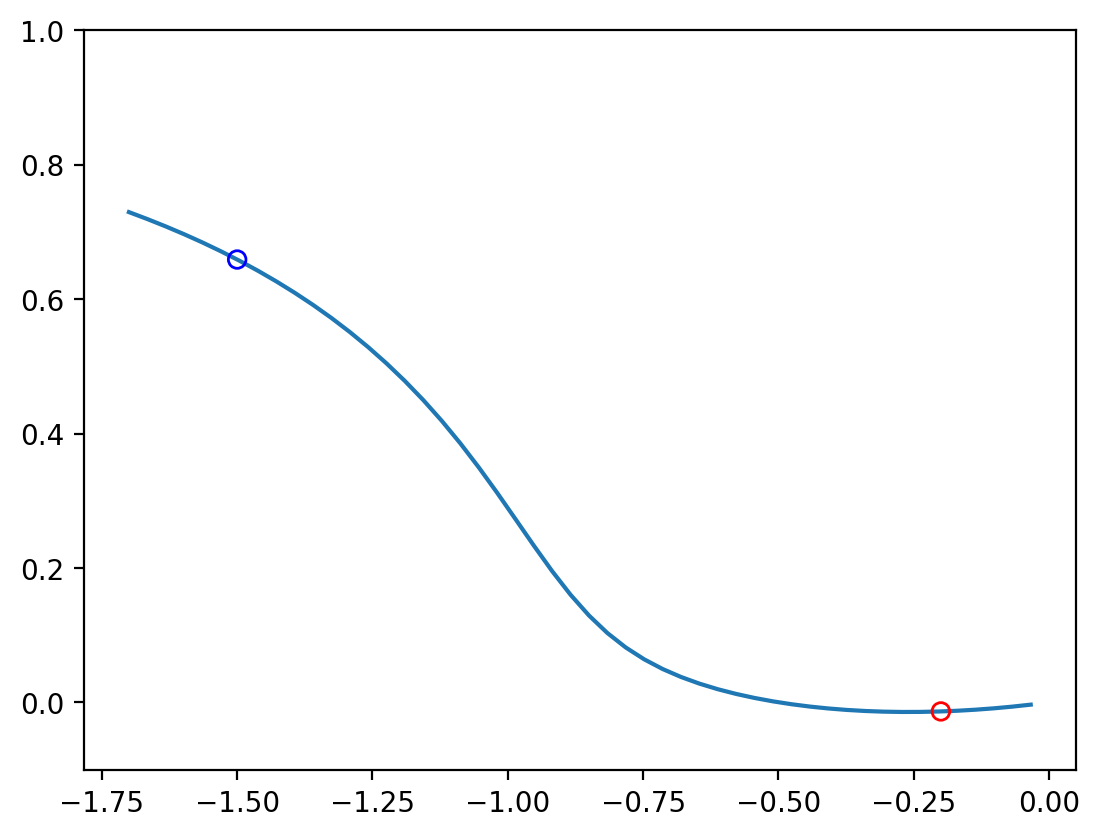

In [126]:
plt.plot(np.arange(-1.7,0,1.7/50),phase_diag_slice_0, zorder=-1)

iteration = 0

_, tmp_eigvect_1 = ground_state(HamiltonianSensor([gx_1_list[iteration]], H0_terms, theta_list[iteration], H_theta_terms, H_out, out_coupl))
_, tmp_eigvect_2 = ground_state(HamiltonianSensor([gx_2_list[iteration]], H0_terms, theta_list[iteration], H_theta_terms, H_out, out_coupl))

plt.scatter([gx_1_list[iteration]], [expectation(tmp_eigvect_1, H_out[0])], facecolors='none', edgecolors='r', s=40, zorder=1)
plt.scatter([gx_2_list[iteration]], [expectation(tmp_eigvect_2, H_out[0])], facecolors='none', edgecolors='b', s=40, zorder=1)

plt.ylim([-.1,1])

plt.savefig('phase_diag_1D_slices_iteration-0.pdf')

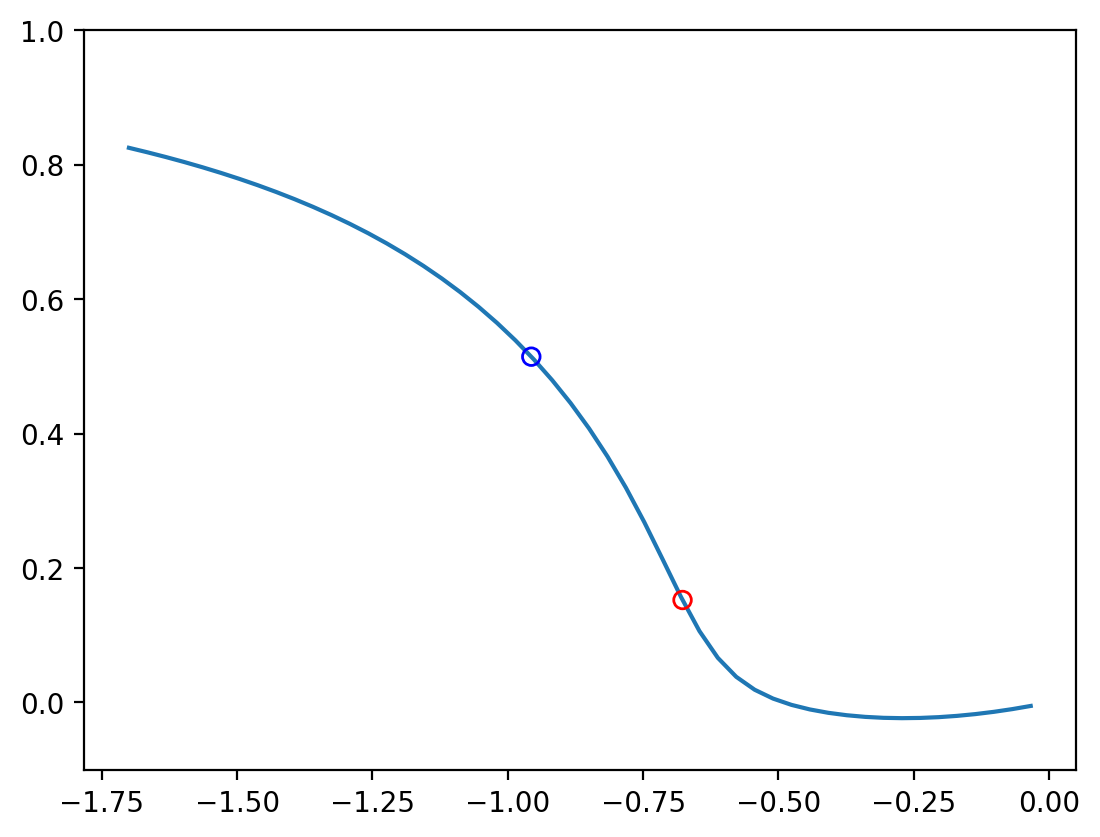

In [127]:
plt.plot(np.arange(-1.7,0,1.7/50),phase_diag_slice_10, zorder=-1)

iteration = 10

_, tmp_eigvect_1 = ground_state(HamiltonianSensor([gx_1_list[iteration]], H0_terms, theta_list[iteration], H_theta_terms, H_out, out_coupl))
_, tmp_eigvect_2 = ground_state(HamiltonianSensor([gx_2_list[iteration]], H0_terms, theta_list[iteration], H_theta_terms, H_out, out_coupl))

plt.scatter([gx_1_list[iteration]], [expectation(tmp_eigvect_1, H_out[0])], facecolors='none', edgecolors='r', s=40, zorder=1)
plt.scatter([gx_2_list[iteration]], [expectation(tmp_eigvect_2, H_out[0])], facecolors='none', edgecolors='b', s=40, zorder=1)

plt.ylim([-.1,1])

plt.savefig('phase_diag_1D_slices_iteration-10.pdf')

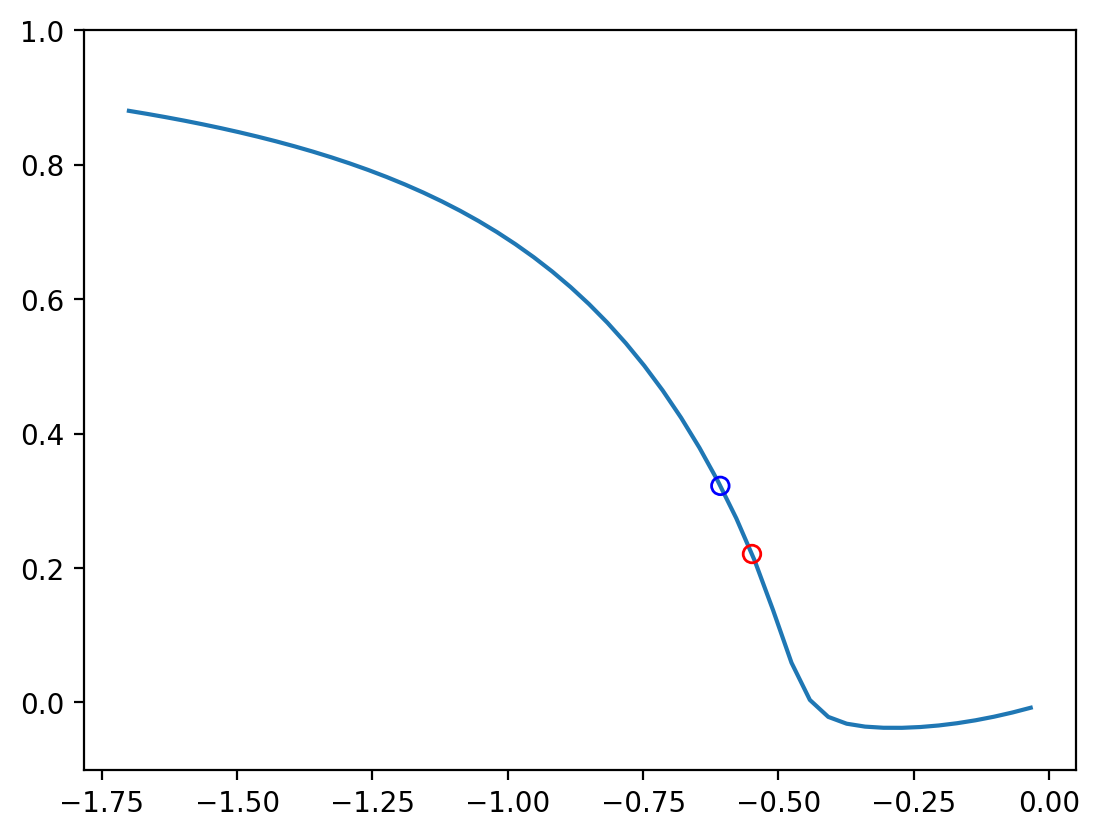

In [128]:
plt.plot(np.arange(-1.7,0,1.7/50),phase_diag_slice_40, zorder=-1)

iteration = 40

_, tmp_eigvect_1 = ground_state(HamiltonianSensor([gx_1_list[iteration]], H0_terms, theta_list[iteration], H_theta_terms, H_out, out_coupl))
_, tmp_eigvect_2 = ground_state(HamiltonianSensor([gx_2_list[iteration]], H0_terms, theta_list[iteration], H_theta_terms, H_out, out_coupl))

plt.scatter([gx_1_list[iteration]], [expectation(tmp_eigvect_1, H_out[0])], facecolors='none', edgecolors='r', s=40, zorder=1)
plt.scatter([gx_2_list[iteration]], [expectation(tmp_eigvect_2, H_out[0])], facecolors='none', edgecolors='b', s=40, zorder=1)

plt.ylim([-.1,1])

plt.savefig('phase_diag_1D_slices_iteration-40.pdf')

Training, run 2: two initial points in same phase

In [130]:
## initialise by hand
theta_start = np.array([1.0])
gx_1_start = np.array([-0.5])
gx_2_start = np.array([0.3])

In [133]:
## initialise
theta = theta_start
gx_1 = gx_1_start
gx_2 = gx_2_start

## learning rate
learning_rate = 1e-1

## number of total runs
number_epochs = 100

## batch size
batch_size = 2

## iterations
number_iterations = number_epochs #int(number_epochs * len(x_train) / batch_size)

## coupling to output operator (when not in nudge phase)
out_coupl = [0.0]

## nudge parameter scaling eta (uses eta * error_signal)
nudge = 1e-1

In [134]:
cost_func_list = np.array([])

learning_rate_decay = 0.0
epoch = 0

gx_1_list = np.array([])
gx_2_list = np.array([])
theta_list = np.array([])

learning_rate_t = learning_rate

for jj in range(0,number_iterations):
    tmp_grad_gx_1, tmp_grad_gx_2, tmp_grad_theta = get_gradient(gx_1, gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl, nudge)
    tmp_cost_func = cost_func(gx_1, gx_2, H0_terms, theta, H_theta_terms, H_out, out_coupl)

    ## learning rate decay
    #learning_rate_t = learning_rate * 1 / (1 + learning_rate_decay * epoch)
    #epoch += 1

    gx_1_list = np.append(gx_1_list, gx_1)
    gx_2_list = np.append(gx_2_list, gx_2)
    theta_list = np.append(theta_list, theta)

    gx_1 -= learning_rate_t * tmp_grad_gx_1.flatten()
    gx_2 -= learning_rate_t * tmp_grad_gx_2.flatten()
    theta -= learning_rate_t * tmp_grad_theta.flatten()

    cost_func_list = np.append(cost_func_list, tmp_cost_func)

gx_1_list = np.append(gx_1_list, gx_1)
gx_2_list = np.append(gx_2_list, gx_2)
theta_list = np.append(theta_list, theta)
cost_func_list = np.append(cost_func_list, tmp_cost_func)

In [ ]:
import os
cwd = os.getcwd()
os.chdir(".") # <-- insert relevant directory here (for saving plots and data).

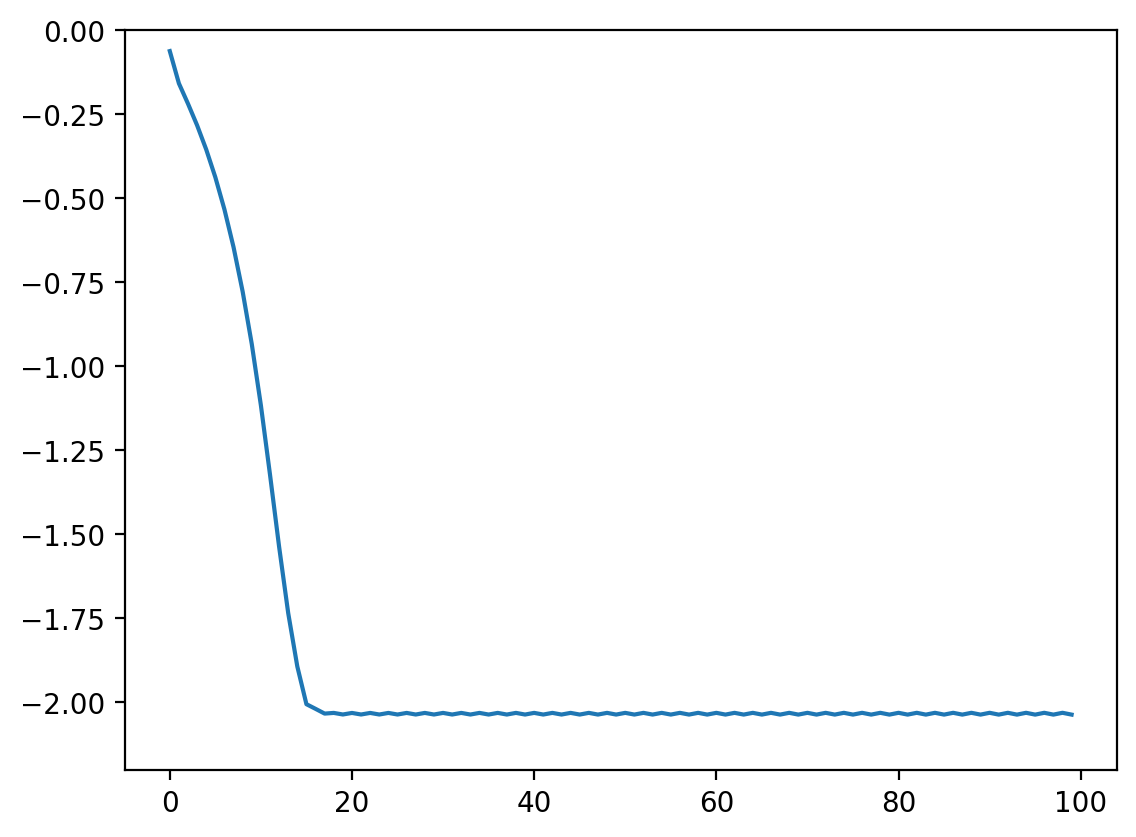

In [137]:
plt.plot(cost_func_list[:100])
plt.ylim([-2.2,0])

plt.savefig('cost_function.pdf')

In [ ]:
## sweep parameters of X[j] term and Z[j] @ Z[j+1] terms
phase_diag_slice = phase_diagram_2D(H_out[0], -1.71, 1.7, 0, np.array([0.0]), out_coupl, 100)

In [138]:
theta_list = theta_list.reshape((number_epochs+1,len(theta)))

In [139]:
np.savetxt("gx_2_list.csv", gx_2_list, delimiter=",")
np.savetxt("gx_1_list.csv", gx_1_list, delimiter=",")
np.savetxt("theta_list_OBC.csv", theta_list, delimiter=",")
np.savetxt("cost_func_list_OBC.csv", cost_func_list, delimiter=",")
np.savetxt("phase_diag_slice_OBC.csv", phase_diag_slice, delimiter=",")

In [142]:
red_color_list = [[x, 0, 0, 1.0] for x in np.arange(0.0,1,1/len(gx_1_list))]
blue_color_list = [[x, 0, 0, 1.0] for x in np.arange(0.0,1,1/len(gx_1_list))]

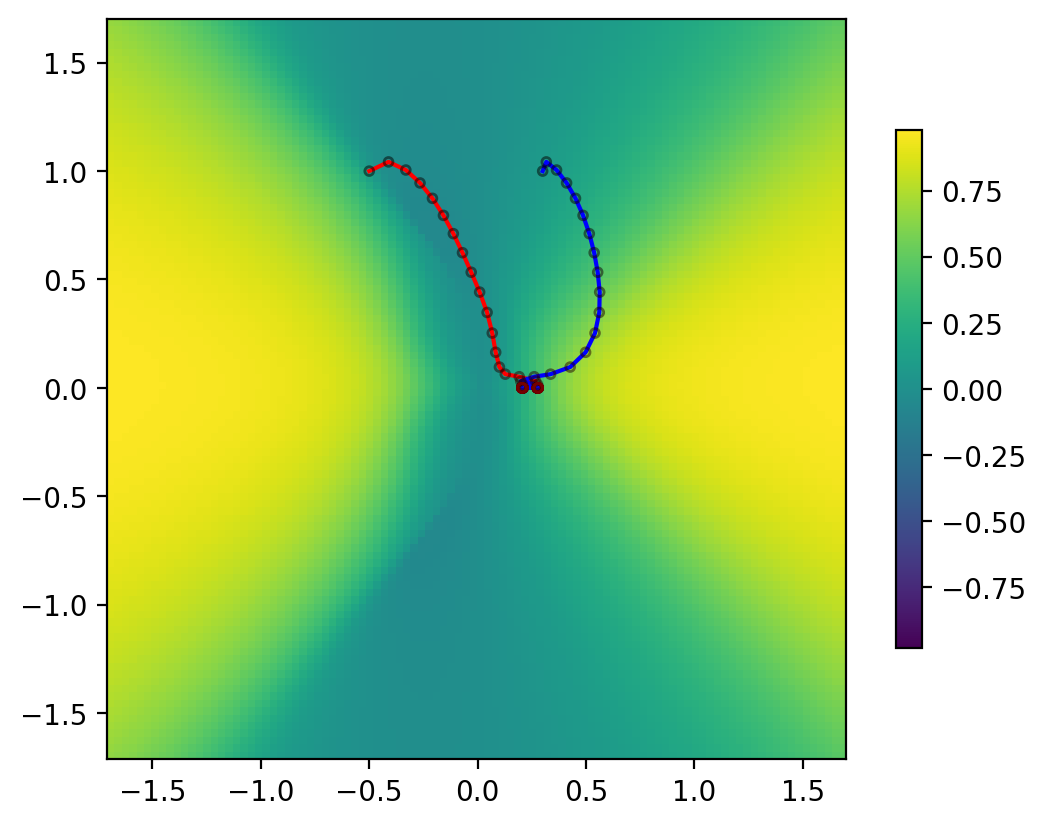

In [144]:
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

plt.imshow(phase_diag_slice, extent = [-1.71, 1.7, -1.71, 1.7],origin='lower',norm=colors.CenteredNorm())
plt.colorbar(shrink = .7)

plt.plot(gx_1_list[:50], theta_list[:50,0], c='r', zorder=0)
plt.plot(gx_2_list[:50], theta_list[:50,0], c='b', zorder=0)

plt.scatter(gx_1_list[:50], theta_list[:50,0], facecolors='none', edgecolors=red_color_list, s=10, zorder=1, alpha=0.5)
plt.scatter(gx_2_list[:50], theta_list[:50,0], facecolors='none', edgecolors=blue_color_list, s=10, zorder=1, alpha=0.5)

plt.savefig('walk_in_phase_diag_2.pdf')

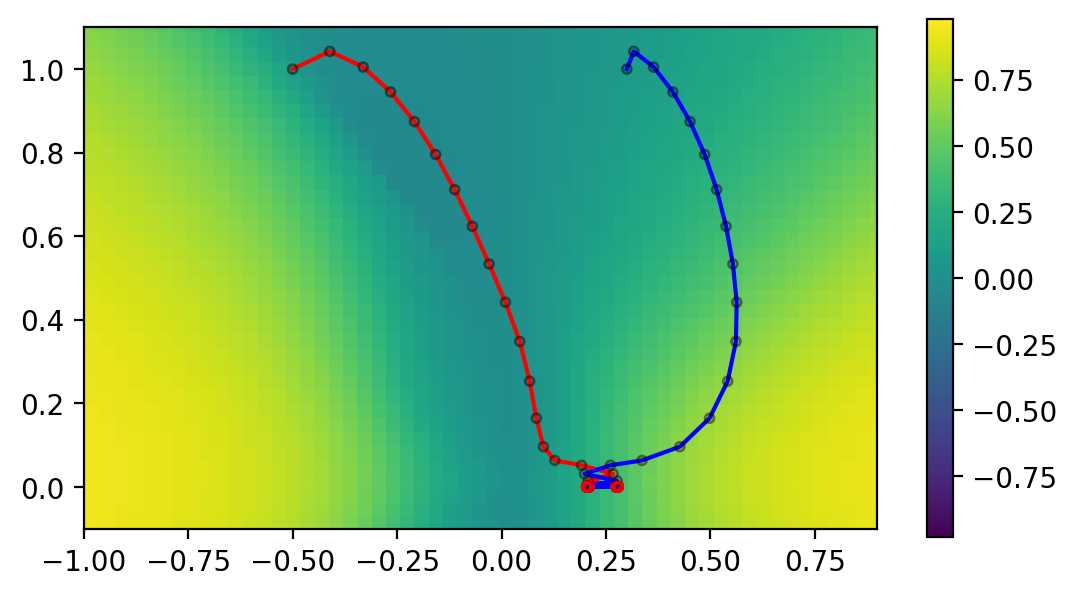

In [146]:
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

plt.imshow(phase_diag_slice, extent = [-1.71, 1.7, -1.71, 1.7],origin='lower',norm=colors.CenteredNorm())
plt.colorbar(shrink = .7)

plt.plot(gx_1_list, theta_list[:,0], c='r', zorder=0)
plt.plot(gx_2_list, theta_list[:,0], c='b', zorder=0)

plt.scatter(gx_1_list, theta_list[:,0], facecolors='none', edgecolors=red_color_list, s=10, zorder=1, alpha=0.5)
plt.scatter(gx_2_list, theta_list[:,0], facecolors='none', edgecolors=blue_color_list, s=10, zorder=1, alpha=0.5)

plt.xlim([-1,.9])
plt.ylim([-.1,1.1])

plt.savefig('walk_in_phase_diag_zoomIn.pdf')